In [2]:
import zipfile

zip_path = "/content/ES_PM_Data.zip"  # Path where Colab puts uploaded files
extract_to = "/content/ES-PM-Data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction complete.")


Extraction complete.


In [3]:
import os
import pandas as pd

# Correct base path after extraction
base_path = "/content/ES-PM-Data/ES_PM_Data"

# Correct file names based on actual ones inside the folder
dl_path = os.path.join(base_path, "DL_Prb_Utilization_Data.csv")
ue_path = os.path.join(base_path, "Avg_UE_Number_Data.csv")

# Load CSV files
df_dl = pd.read_csv(dl_path)
df_ue = pd.read_csv(ue_path)

# Preview first few rows
df_dl.head(), df_ue.head()


(          Timestamp        NCI      gNB  DL_Prb_Utilization
 0  02-01-2024 00:00  357783981  1397593                  24
 1  02-01-2024 00:00  357783979  1397593                  24
 2  02-01-2024 00:00  357783980  1397593                  13
 3  02-01-2024 00:00  358531244  1400512                  29
 4  02-01-2024 00:00  358531245  1400512                  21,
           Timestamp        NCI      gNB  Avg_UE_Number
 0  02-01-2024 00:00  357783981  1397593             10
 1  02-01-2024 00:00  357783979  1397593              3
 2  02-01-2024 00:00  357783980  1397593              8
 3  02-01-2024 00:00  358531244  1400512              7
 4  02-01-2024 00:00  358531245  1400512              8)

In [4]:
print("DL CSV Columns:", df_dl.columns.tolist())
print("UE CSV Columns:", df_ue.columns.tolist())


DL CSV Columns: ['Timestamp', 'NCI', 'gNB', 'DL_Prb_Utilization']
UE CSV Columns: ['Timestamp', 'NCI', 'gNB', 'Avg_UE_Number']


In [5]:
# Step 1: Parse timestamps with mixed formats
df_dl['Timestamp'] = pd.to_datetime(df_dl['Timestamp'], format='mixed', errors='coerce')
df_ue['Timestamp'] = pd.to_datetime(df_ue['Timestamp'], format='mixed', errors='coerce')

# Step 2: Drop rows with bad timestamps
df_dl.dropna(subset=['Timestamp'], inplace=True)
df_ue.dropna(subset=['Timestamp'], inplace=True)

# Step 3: Keep only necessary columns
df_dl = df_dl[['Timestamp', 'DL_Prb_Utilization']]
df_ue = df_ue[['Timestamp', 'Avg_UE_Number']]

# Step 4: Merge on timestamp
df_merged = pd.merge(df_dl, df_ue, on='Timestamp', how='inner')
df_merged.set_index('Timestamp', inplace=True)
df_merged.sort_index(inplace=True)

# Step 5: Resample into 30-minute intervals
df_30min = df_merged.resample('30T').mean().dropna()

# Preview
df_30min.head()


/tmp/ipython-input-5-3805821625.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_30min = df_merged.resample('30T').mean().dropna()


,DL_Prb_Utilization,Avg_UE_Number
Timestamp,,
2024-02-01 00:00:00,18.666667,6.333333
2024-02-01 00:30:00,22.500000,4.250000
2024-02-01 01:00:00,17.583333,4.916667
2024-02-01 01:30:00,19.250000,5.750000
2024-02-01 02:00:00,18.166667,5.000000


In [6]:
!pip install prophet --quiet

from prophet import Prophet
import matplotlib.pyplot as plt


In [7]:
print(df_30min.columns)


Index(['DL_Prb_Utilization', 'Avg_UE_Number'], dtype='object')


In [8]:
# Prepare data for Prophet - DL PRB Utilization
df_dl_prophet = df_30min[['DL_Prb_Utilization']].reset_index()
df_dl_prophet.rename(columns={'Timestamp': 'ds', 'DL_Prb_Utilization': 'y'}, inplace=True)

# Prepare data for Prophet - Avg UE Number
df_ue_prophet = df_30min[['Avg_UE_Number']].reset_index()
df_ue_prophet.rename(columns={'Timestamp': 'ds', 'Avg_UE_Number': 'y'}, inplace=True)


In [9]:
# Install Prophet if not already installed
!pip install prophet --quiet

from prophet import Prophet

# Define how far to forecast — 6 months of 30-minute intervals
periods = 6 * 30 * 48  # = 8640 time steps

# Forecast for DL_Prb_Utilization
m_dl = Prophet()
m_dl.fit(df_dl_prophet)
future_dl = m_dl.make_future_dataframe(periods=periods, freq='30min')
forecast_dl = m_dl.predict(future_dl)

# Forecast for Avg_UE_Number
m_ue = Prophet()
m_ue.fit(df_ue_prophet)
future_ue = m_ue.make_future_dataframe(periods=periods, freq='30min')
forecast_ue = m_ue.predict(future_ue)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfd9uupup/ptw9nh62.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfd9uupup/xt1zokct.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28338', 'data', 'file=/tmp/tmpfd9uupup/ptw9nh62.json', 'init=/tmp/tmpfd9uupup/xt1zokct.json', 'output', 'file=/tmp/tmpfd9uupup/prophet_modelb8rqmin3/prophet_model-20250705061132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:11:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:11:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/t

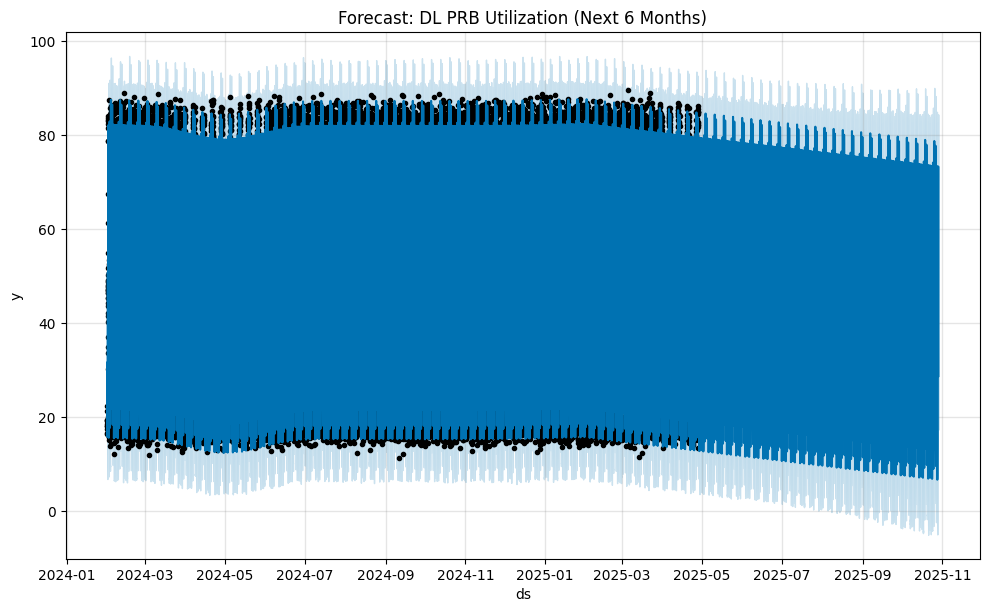

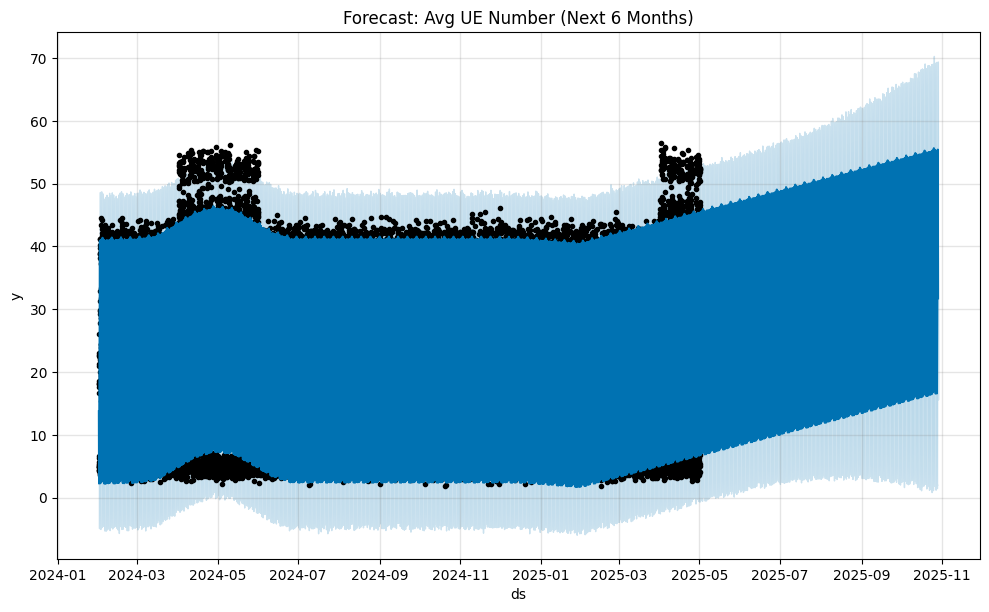

In [10]:
import matplotlib.pyplot as plt

# Plot DL PRB Utilization forecast
m_dl.plot(forecast_dl)
plt.title("Forecast: DL PRB Utilization (Next 6 Months)")
plt.show()

# Plot Avg UE Number forecast
m_ue.plot(forecast_ue)
plt.title("Forecast: Avg UE Number (Next 6 Months)")
plt.show()


In [11]:
# Save DL PRB forecast
forecast_dl[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("forecast_DL_PRB_Utilization.csv", index=False)

# Save UE Number forecast
forecast_ue[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("forecast_Avg_UE_Number.csv", index=False)


In [12]:
# Ensure timestamps are datetime
forecast_dl['ds'] = pd.to_datetime(forecast_dl['ds'])
forecast_ue['ds'] = pd.to_datetime(forecast_ue['ds'])

# Merge both forecasts on timestamp
merged_forecast = pd.merge(
    forecast_dl[['ds', 'yhat']].rename(columns={'yhat': 'DL_Prb_Utilization'}),
    forecast_ue[['ds', 'yhat']].rename(columns={'yhat': 'Avg_UE_Number'}),
    on='ds',
    how='inner'
)

# Optional: Rename 'ds' to 'Timestamp' for clarity
merged_forecast.rename(columns={'ds': 'Timestamp'}, inplace=True)

# Preview
merged_forecast.head()


,Timestamp,DL_Prb_Utilization,Avg_UE_Number
0,2024-02-01 00:00:00,31.622134,13.748771
1,2024-02-01 00:30:00,26.545156,10.626313
2,2024-02-01 01:00:00,22.509511,7.931093
3,2024-02-01 01:30:00,19.515390,5.721433
4,2024-02-01 02:00:00,17.489796,4.034696


In [13]:
# Set window size (in minutes)
window_minutes = 30  # Can be modified by user

# Filter rows that are spaced at least `window_minutes` apart
merged_forecast = merged_forecast.sort_values('Timestamp')

# Keep only timestamps that are spaced properly (if needed for custom windowing logic)
# Here, we just ensure continuity in time series
# But you could downsample if needed
filtered_forecast = merged_forecast.copy()  # Placeholder for more advanced filtering

# Save to CSV
filtered_forecast.to_csv("Overlapping_Forecast_Window.csv", index=False)


In [15]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Merge forecast with actuals for evaluation (only on known data)
df_dl_eval = df_dl_prophet.merge(forecast_dl[['ds', 'yhat']], on='ds')

# Calculate error metrics
mape_dl = mean_absolute_percentage_error(df_dl_eval['y'], df_dl_eval['yhat']) * 100
rmse_dl = np.sqrt(mean_squared_error(df_dl_eval['y'], df_dl_eval['yhat']))

# Calculate Accuracy in percentage
accuracy_dl = 100 - mape_dl

# Print results
print(f"✅ DL PRB Utilization - Accuracy: {accuracy_dl:.2f}%")
print(f"📉 DL PRB Utilization - MAPE: {mape_dl:.2f}%")
print(f"📉 DL PRB Utilization - RMSE: {rmse_dl:.2f}")


✅ DL PRB Utilization - Accuracy: 86.28%
📉 DL PRB Utilization - MAPE: 13.72%
📉 DL PRB Utilization - RMSE: 6.80
